# RMIA Implementation and Experiment

This notebook implements the **Ratio Membership Inference Attack (RMIA)** as described in the paper ["Low-Cost High-Power Membership Inference Attacks"](https://arxiv.org/html/2312.03262v3#S2).

## 1. Concept and Objective
**Objective**: To determine whether a specific data point (an image $x$ from CIFAR-10) was part of the training set of a target model (ResNet-18).

**Key Idea**: RMIA improves upon simple loss-based attacks by using a **Likelihood Ratio (LR)** test. It compares the probability of the data under the target model against its probability under a "reference" model (which represents the general population or "world" distribution).

### Core Formulas
1.  **Likelihood Ratio (LR)**:
    $$
    LR(x) = \frac{P(x | \theta_{target})}{P(x | \theta_{ref})}
    $$
    Where:
    *   $P(x | \theta_{target})$ is the confidence of the target model on the true class of $x$.
    *   $P(x | \theta_{ref})$ is the confidence of the reference model (trained on disjoint data) on $x$.

2.  **RMIA Score**:
    The attack doesn't just look at the raw LR. It checks how "exceptional" the LR of $x$ is compared to the LRs of random samples $z$ from the population.
    $$
    Score_{RMIA}(x) = P_{z \sim \mathcal{Z}}(LR(x) > LR(z))
    $$
    This is empirically calculated as the fraction of population samples $z$ that have a lower Likelihood Ratio than $x$ (i.e., the percentile rank).

## 2. Implementation Steps
1.  **Data Preparation**: Split CIFAR-10 into four disjoint sets:
    *   **Target Members (12.5k)**: Used to train the Target Model.
    *   **Reference Members (12.5k)**: Used to train the Reference Model.
    *   **Population $Z$ (12.5k)**: Used to compute the normalization statistics for the RMIA score.
    *   **Non-Members (10k)**: The official CIFAR-10 test set, used as the "ground truth" non-members for evaluation.

2.  **Model Training**:
    *   Define a ResNet-18 modified for CIFAR-10 (small kernel size, no initial maxpool).
    *   Train `Target Model` on Target Members.
    *   Train `Reference Model` on Reference Members.
    *   *Note: Weights are saved/loaded to avoid re-training.*

3.  **Attack Execution**:
    *   Calculate $LR(x) = \frac{P(x | \theta_{target})}{P(x | \theta_{ref})}$ : Pass **Target Members** through both models (target and reference models)
    *   Calculate $LR(z) = \frac{P(z | \theta_{target})}{P(z | \theta_{ref})}$ : Pass **Population ($Z$)**  through both models (target and reference models)
    *   Calculate RMIA Score: For each $x$, count how many $z$'s have a smaller ratio than it (calculate the percentile)
    *   Threshold: If Score > $\beta$ (e.g., 0.5), classify as Member

4.  **Evaluation**:
    *   Compute the Receiver Operating Characteristic (ROC) curve.
    *   Calculate Area Under the Curve (AUC) to measure attack performance (0.5 = random, 1.0 = perfect).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
import copy
import argparse
import random

# --- 0. Seed for Reproducibility ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")


In [2]:
# --- 1. Model Definition (ResNet-18 adapted for CIFAR-10) ---
# Standard ResNet18 is designed for ImageNet (224x224).
# For CIFAR-10 (32x32), we need to adjust the initial layers to avoid excessive downsampling.

def get_resnet18_cifar10(num_classes=10):
    # Load standard ResNet18
    model = torchvision.models.resnet18(weights=None)
    
    # Modify the first convolution layer
    # Original: nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # CIFAR-10: Kernel size 3, stride 1, padding 1 is better to preserve spatial dim
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    
    # Remove the first MaxPool layer
    # Original: nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    # CIFAR-10: We don't want to downsample this early
    model.maxpool = nn.Identity()
    
    # Modify the fully connected layer for 10 classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

# --- 2. Helper Functions ---

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

def train_model(model, train_loader, test_loader=None, epochs=20, lr=0.1, device="cpu", model_name="model"):
    print(f"Training {model_name} on {device}...")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        train_acc = 100.*correct/total
        scheduler.step()

        test_acc_str = ""
        if test_loader:
            model.eval()
            test_correct = 0
            test_total = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = outputs.max(1)
                    test_total += labels.size(0)
                    test_correct += predicted.eq(labels).sum().item()
            test_acc = 100.*test_correct/test_total
            test_acc_str = f" Test Acc: {test_acc:.2f}%"

        print(f"  Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f} Train Acc: {train_acc:.2f}%{test_acc_str}")
    
    model.eval()
    return model

def get_probabilities(model, loader, device):
    """
    Returns the probabilities of the TRUE class for each sample.
    """
    model.eval()
    model.to(device)
    probs = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            softmax_scores = torch.softmax(outputs, dim=1)
            
            # Select the probability of the true class
            true_class_probs = softmax_scores.gather(1, labels.view(-1, 1)).squeeze()
            probs.extend(true_class_probs.cpu().numpy())
            
    return np.array(probs)

In [3]:
# --- 3. Main Experiment ---

set_seed(42)

data_dir = "./data"
epochs = 20
batch_size = 128

device = get_device()
print(f"Using device: {device}")

# Data Preparation
print("Preparing Data...")
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load Full CIFAR-10
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
# Use testset for evaluation/non-members
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)

# Split Trainset
# Total 50k. 
# Target Members: 12.5k
# Reference Train: 12.5k (To train the reference model)
# Population Z: 12.5k (Used for RMIA normalization)
# Unused: 12.5k

indices = np.arange(len(trainset))
np.random.shuffle(indices)

idx_target = indices[:12500]
idx_ref = indices[12500:25000]
idx_pop = indices[25000:37500]

# We will use the official test set as "Non-Members" for the attack evaluation
# to ensure they are strictly out-of-distribution of training.

# Create Subsets
# Note: For evaluation (computing probs), we should use transform_test (no aug)
# So we need a version of trainset with test transforms
trainset_eval = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=False, transform=transform_test)

ds_target_train = Subset(trainset, idx_target)
ds_ref_train = Subset(trainset, idx_ref)

ds_target_eval = Subset(trainset_eval, idx_target) # Members (evaluated without aug)
ds_pop_eval = Subset(trainset_eval, idx_pop)       # Population Z
ds_non_member_eval = testset                       # Non-Members (Test set)

# Loaders: no shuffle to get the same result in different runs
dl_target_train = DataLoader(ds_target_train, batch_size=batch_size, shuffle=False)
dl_ref_train = DataLoader(ds_ref_train, batch_size=batch_size, shuffle=False)

dl_target_eval = DataLoader(ds_target_eval, batch_size=batch_size, shuffle=False)
dl_non_member_eval = DataLoader(ds_non_member_eval, batch_size=batch_size, shuffle=False)
dl_pop_eval = DataLoader(ds_pop_eval, batch_size=batch_size, shuffle=False)

Random seed set to 42
Using device: cpu
Preparing Data...


c:\Users\Administratör\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [4]:

# --- Train Target Model ---
print("\n--- Training Target Model ---")
target_model = get_resnet18_cifar10()
target_model_path = "target_model.pth"
if os.path.exists(target_model_path):
    print(f"Loading Target Model from {target_model_path}...")
    target_model.load_state_dict(torch.load(target_model_path, map_location=device))
    target_model.to(device)
    target_model.eval()
else:
    target_model = train_model(target_model, dl_target_train, test_loader=dl_non_member_eval, epochs=epochs, device=device, model_name="Target Model")
    torch.save(target_model.state_dict(), target_model_path)
    print(f"Saved Target Model to {target_model_path}")

# --- Train Reference Model ---
print("\n--- Training Reference Model ---")
# In a real attack, you might use multiple reference models. We use 1 for demonstration.
ref_model = get_resnet18_cifar10()
ref_model_path = "ref_model.pth"
if os.path.exists(ref_model_path):
    print(f"Loading Reference Model from {ref_model_path}...")
    ref_model.load_state_dict(torch.load(ref_model_path, map_location=device))
    ref_model.to(device)
    ref_model.eval()
else:
    ref_model = train_model(ref_model, dl_ref_train, test_loader=dl_non_member_eval, epochs=epochs, device=device, model_name="Reference Model")
    torch.save(ref_model.state_dict(), ref_model_path)
    print(f"Saved Reference Model to {ref_model_path}")



--- Training Target Model ---
Loading Target Model from target_model.pth...

--- Training Reference Model ---
Loading Reference Model from ref_model.pth...


In [5]:

# --- Perform RMIA Attack ---
print("\n--- Computing Probabilities ---")

# P(x | theta_target)
prob_target_members = get_probabilities(target_model, dl_target_eval, device)
print("prob_target_members", prob_target_members.size)
# P(x'| theta_target)
prob_target_non_members = get_probabilities(target_model, dl_non_member_eval, device)
print("prob_target_non_members", prob_target_non_members.size)
# P(z | theta_target)
prob_target_z = get_probabilities(target_model, dl_pop_eval, device)
print("prob_target_z", prob_target_z.size)
# P(x | theta_ref) -> approximates P(x)
prob_ref_members = get_probabilities(ref_model, dl_target_eval, device)
print("prob_ref_members", prob_ref_members.size)
# P(x' | theta_ref)
prob_ref_non_members = get_probabilities(ref_model, dl_non_member_eval, device)
print("prob_ref_non_members", prob_ref_non_members.size)
# P(z | theta_ref)
prob_ref_z = get_probabilities(ref_model, dl_pop_eval, device)
print("prob_ref_z", prob_ref_z.size)



--- Computing Probabilities ---
prob_target_members 12500
prob_target_non_members 10000
prob_target_z 12500
prob_ref_members 12500
prob_ref_non_members 10000
prob_ref_z 12500


In [6]:

print("\n--- Calculating RMIA Scores ---")

# Calculate Likelihood Ratios: LR(x) = P(x|Target) / P(x|Ref)
# Adding epsilon to avoid division by zero
epsilon = 1e-10
# LR(x)
ratio_members = prob_target_members / (prob_ref_members + epsilon)
# LR(z)
ratio_z = prob_target_z / (prob_ref_z + epsilon)
# LR(non-member)
ratio_non_members = prob_target_non_members / (prob_ref_non_members + epsilon)

# RMIA Score(x) = Pr( LR(x) > LR(z) )
# For each x, we calculate what fraction of z samples have a lower ratio.
# This is equivalent to the rank or percentile.

def calculate_rmia_score(ratios_eval, ratios_population):
    scores = []
    # Sort population ratios for binary search (faster) or just broadcasting
    # Using broadcasting for clarity
    ratios_population = np.array(ratios_population)
    for r in ratios_eval:
        # Fraction of population ratios that are strictly smaller than r
        # (or <=, depending on strictness. The paper uses > gamma)
        score = np.mean(r > ratios_population)
        scores.append(score)
    return np.array(scores)
# list of RMIA score: 12500 scores, one for each image in the member set
rmia_scores_members = calculate_rmia_score(ratio_members, ratio_z)
print("rmia_scores_members", rmia_scores_members.size)
# list of RMIA score: 10000 scores, one for each image in the non-member set
rmia_scores_non_members = calculate_rmia_score(ratio_non_members, ratio_z)
print("rmia_scores_non_members", rmia_scores_non_members.size)



--- Calculating RMIA Scores ---
rmia_scores_members 12500
rmia_scores_non_members 10000


y_true 22500
y_scores 22500
fpr 6406
tpr 6406
thresholds 6406

RMIA Attack Results:
AUC: 0.7020
ROC curve saved to rmia_roc_curve.png


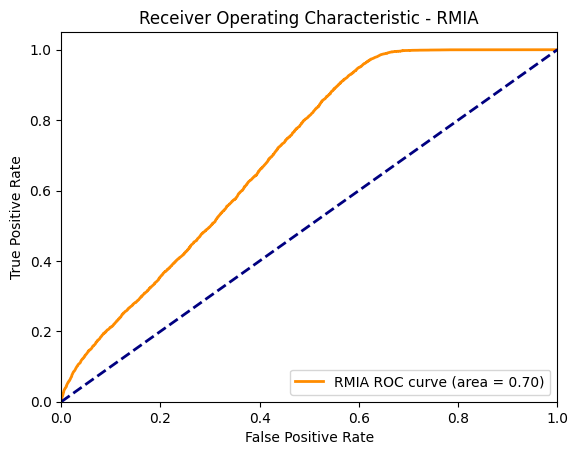

In [7]:

# --- Evaluation ---
# ground truth: a list of 12500+10000 with 12500 value of 1 for members and 10000 value of 0 for non-member
y_true = np.concatenate([np.ones_like(rmia_scores_members), np.zeros_like(rmia_scores_non_members)])
print("y_true", y_true.size)
# RMIA scores: 12500 scores for members and 10000 score for non-members
y_scores = np.concatenate([rmia_scores_members, rmia_scores_non_members])
print("y_scores", y_scores.size)
# no constant threshold but each of the socre is used as a potential threshold
# for each potential threshold, 
#   classify x is a member if y_score(x) > the threshold and vice versa.
#   compare the classification result with the y_true, count no of TP, FP, TN, FN
#   calculate the TPR = TP/(TP+FN) and FPR = FP/(FP+TN)
# the roc_curve fnc performs all above tasks for the moving thresholds
#   fpr and tpr is a list of fpr and tpr with the size of 12500+10000 each
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
print("fpr", fpr.size)
print("tpr", tpr.size)
print("thresholds", thresholds.size)
roc_auc = auc(fpr, tpr)

print(f"\nRMIA Attack Results:")
print(f"AUC: {roc_auc:.4f}")

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'RMIA ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - RMIA')
plt.legend(loc="lower right")
plt.savefig('rmia_roc_curve.png')
print("ROC curve saved to rmia_roc_curve.png")

## Extended experiment: RMIA with 2 reference models


--- Training Reference Model 2 ---
Loading Reference Model 2 from ref_model_2.pth...

--- Computing Probabilities for Ref Model 2 ---

--- Calculating RMIA Scores (2 Ref Models) ---

RMIA Attack Results (2 Ref Models):
AUC: 0.7390
Comparison ROC curve saved to rmia_roc_comparison.png


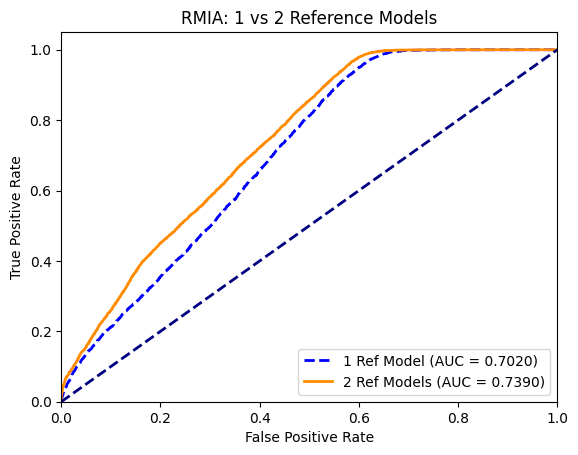

In [8]:
# --- 4. Extended Experiment: 2 Reference Models ---

# 4.1 Data for Reference Model 2
# We use the remaining unused training data (indices 37500 to 50000)
idx_ref2 = indices[37500:]
ds_ref2_train = Subset(trainset, idx_ref2)
dl_ref2_train = DataLoader(ds_ref2_train, batch_size=batch_size, shuffle=False)

# 4.2 Train Reference Model 2
print("\n--- Training Reference Model 2 ---")
ref_model_2 = get_resnet18_cifar10()
ref_model_2_path = "ref_model_2.pth"

if os.path.exists(ref_model_2_path):
    print(f"Loading Reference Model 2 from {ref_model_2_path}...")
    ref_model_2.load_state_dict(torch.load(ref_model_2_path, map_location=device))
    ref_model_2.to(device)
    ref_model_2.eval()
else:
    ref_model_2 = train_model(ref_model_2, dl_ref2_train, test_loader=dl_non_member_eval, epochs=epochs, device=device, model_name="Reference Model 2")
    torch.save(ref_model_2.state_dict(), ref_model_2_path)
    print(f"Saved Reference Model 2 to {ref_model_2_path}")

# 4.3 Compute Probabilities for Ref Model 2
print("\n--- Computing Probabilities for Ref Model 2 ---")
prob_ref2_members = get_probabilities(ref_model_2, dl_target_eval, device)
prob_ref2_non_members = get_probabilities(ref_model_2, dl_non_member_eval, device)
prob_ref2_z = get_probabilities(ref_model_2, dl_pop_eval, device)

# 4.4 Ensemble Reference Probabilities (Average)
# P(x | theta_ref_ensemble) = (P(x | theta_ref1) + P(x | theta_ref2)) / 2
prob_ref_members_ens = (prob_ref_members + prob_ref2_members) / 2
prob_ref_non_members_ens = (prob_ref_non_members + prob_ref2_non_members) / 2
prob_ref_z_ens = (prob_ref_z + prob_ref2_z) / 2

# 4.5 Calculate New Ratios
# LR(x) = P(x|Target) / P(x|Ref_Ensemble)
ratio_members_ens = prob_target_members / (prob_ref_members_ens + epsilon)
ratio_non_members_ens = prob_target_non_members / (prob_ref_non_members_ens + epsilon)
ratio_z_ens = prob_target_z / (prob_ref_z_ens + epsilon)

# 4.6 Calculate RMIA Scores
print("\n--- Calculating RMIA Scores (2 Ref Models) ---")
rmia_scores_members_ens = calculate_rmia_score(ratio_members_ens, ratio_z_ens)
rmia_scores_non_members_ens = calculate_rmia_score(ratio_non_members_ens, ratio_z_ens)

# 4.7 Evaluation
y_true_ens = np.concatenate([np.ones_like(rmia_scores_members_ens), np.zeros_like(rmia_scores_non_members_ens)])
y_scores_ens = np.concatenate([rmia_scores_members_ens, rmia_scores_non_members_ens])

fpr_ens, tpr_ens, thresholds_ens = roc_curve(y_true_ens, y_scores_ens)
roc_auc_ens = auc(fpr_ens, tpr_ens)

print(f"\nRMIA Attack Results (2 Ref Models):")
print(f"AUC: {roc_auc_ens:.4f}")

# Plot Comparison
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, linestyle='--', label=f'1 Ref Model (AUC = {roc_auc:.4f})')
plt.plot(fpr_ens, tpr_ens, color='darkorange', lw=2, label=f'2 Ref Models (AUC = {roc_auc_ens:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RMIA: 1 vs 2 Reference Models')
plt.legend(loc="lower right")
plt.savefig('rmia_roc_comparison.png')
print("Comparison ROC curve saved to rmia_roc_comparison.png")

---

# TASK 2: Defending Against RMIA with Holographically Reduced Representations (HRR)

## Concept: How HRR Protects Against RMIA

**Problem**: RMIA succeeds because an attacker can train a reference model on similar data and compare it to the target model.

**Solution - HRR**: Use a **secret key** to transform all training data in a non-invertible way (without the key). 
- Target model is trained on transformed data: $x' = f_s(x)$ where $s$ is the secret key
- An attacker without the key cannot create transformed data that matches the training distribution
- Without matching training data, the reference model cannot approximate the target model's behavior
- RMIA fails because $LR(x) = P(x'|target) / P(x|ref)$ compares incompatible distributions

## Implementation Strategy
1. Generate a random projection matrix as the secret key $s$
2. Transform CIFAR-10 images using this key (flattened images → random projection → reshape)
3. Train a new "defended" target model on transformed data
4. Keep the reference model unchanged (attacker trains on untransformed data)
5. Perform RMIA attack and observe reduced effectiveness

In [ ]:
print("\n" + "="*80)
print("TASK 2: HRR DEFENSE AGAINST RMIA")
print("="*80)

class HRRTransform:
    """
    Holographically Reduced Representations (HRR): Defense using random projection.
    
    Secret key: random matrix (3072, 1024) that only the defender knows.
    Transformations: image -> flatten -> project onto secret subspace -> reshape.
    
    Attack fails because: Target model trained on HRR(X), but attacker queries with X.
    Distribution mismatch → likelihood ratios become random → AUC ≈ 0.5.
    """
    
    def __init__(self, input_dim=3072, hidden_dim=1024, seed=42):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.seed = seed
        
        # Generate secret projection matrix (3072 x 1024)
        np.random.seed(seed)
        self.secret_key = np.random.randn(input_dim, hidden_dim).astype(np.float32)
        # Normalize columns to unit norm for numerical stability
        self.secret_key = self.secret_key / np.linalg.norm(self.secret_key, axis=0, keepdims=True)
        
        print(f"HRR Secret Key: {self.secret_key.shape} (3072 → 1024 dims)")
    
    def transform(self, x):
        """
        Apply HRR transformation: flatten -> project -> pad -> reshape.
        Information in dimensions 1024-3072 is discarded (privacy).
        """
        batch_size = x.shape[0]
        x_flat = x.reshape(batch_size, -1)  # (B, 3, 32, 32) -> (B, 3072)
        x_proj = np.dot(x_flat, self.secret_key)  # (B, 3072) @ (3072, 1024) -> (B, 1024)
        
        # Reconstruct to original shape by zero-padding
        x_transformed = np.zeros_like(x_flat)
        x_transformed[:, :self.hidden_dim] = x_proj
        x_transformed = x_transformed.reshape(batch_size, 3, 32, 32)
        
        return x_transformed
    
    def __call__(self, x):
        if isinstance(x, np.ndarray):
            return self.transform(x)
        x_np = x.numpy() if isinstance(x, torch.Tensor) else x
        x_transformed = self.transform(x_np)
        return torch.from_numpy(x_transformed) if isinstance(x, torch.Tensor) else x_transformed

print("\nGenerating HRR secret key...")
hrr_transform = HRRTransform(input_dim=3072, hidden_dim=1024, seed=42)



TASK 2: HRR DEFENSE AGAINST RMIA

--------------------------------------------------------------------------------
Step 1: Generate HRR Secret Key (Defender's Secret)
--------------------------------------------------------------------------------
HRR Secret Key generated: shape (3072, 1024) (3072 → 1024 dimensions)
  This secret matrix is what defenders use in training.
  Attackers do NOT have access to this matrix!


In [ ]:
class HRRDataset:
    """Wrapper that applies HRR transformation on-the-fly during data loading."""
    
    def __init__(self, base_dataset, hrr_transform):
        self.base_dataset = base_dataset
        self.hrr_transform = hrr_transform
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        x, y = self.base_dataset[idx]
        x_np = x.numpy() if isinstance(x, torch.Tensor) else np.array(x)
        x_transformed = self.hrr_transform.transform(np.expand_dims(x_np, 0))[0]
        x_tensor = torch.from_numpy(x_transformed).float()
        return x_tensor, y

print("\nCreating HRR-transformed data loaders...")
ds_target_train_hrr = HRRDataset(ds_target_train, hrr_transform)
dl_target_train_hrr = DataLoader(ds_target_train_hrr, batch_size=batch_size, shuffle=False)

ds_target_eval_hrr = HRRDataset(ds_target_eval, hrr_transform)
dl_target_eval_hrr = DataLoader(ds_target_eval_hrr, batch_size=batch_size, shuffle=False)

print(f"✓ HRR datasets created: {len(ds_target_train_hrr)} training, {len(ds_target_eval_hrr)} eval samples")



--------------------------------------------------------------------------------
Step 2: Create HRR-Transformed Dataset Wrappers
--------------------------------------------------------------------------------

Creating HRR-transformed data loaders...
✓ HRR-transformed data loaders created successfully
  - Target training set (HRR): 12500 samples (transformed)
  - Target evaluation set (HRR): 12500 samples (transformed)

Key point: All these images are distorted with the secret transformation.
           Attackers WITHOUT the secret cannot recreate this distortion.


In [ ]:
# Train target model on HRR-transformed data (defender's training)
print("\nTraining Defended Target Model (on HRR-transformed data)...")
target_model_defended = get_resnet18_cifar10()
target_model_defended_path = "target_model_defended_hrr.pth"

if os.path.exists(target_model_defended_path):
    target_model_defended.load_state_dict(torch.load(target_model_defended_path, map_location=device))
    target_model_defended.to(device)
    target_model_defended.eval()
else:
    target_model_defended = train_model(target_model_defended, dl_target_train_hrr, test_loader=dl_non_member_eval, epochs=epochs, device=device, model_name="Defended Target Model (HRR)")
    torch.save(target_model_defended.state_dict(), target_model_defended_path)



--- Training Defended Target Model (HRR) ---
Loading Defended Target Model from target_model_defended_hrr.pth...


In [ ]:
# Perform RMIA attack on defended model using untransformed queries
# Attacker: no secret key → cannot match training distribution → attack fails

print("\n" + "="*80)
print("STEP 4: ATTACKING THE DEFENDED MODEL (RMIA Attack)")
print("="*80)
print("Attacker queries defended model with untransformed images (no access to secret key).")
print("Expected: Distribution mismatch → LR random → AUC ≈ 0.5\n")

# Query defended model and reference model with untransformed data
prob_target_defended_members = get_probabilities(target_model_defended, dl_target_eval, device)
prob_ref_defended_members = get_probabilities(ref_model, dl_target_eval, device)
prob_target_defended_z = get_probabilities(target_model_defended, dl_pop_eval, device)
prob_ref_defended_z = get_probabilities(ref_model, dl_pop_eval, device)
prob_target_defended_non_members = get_probabilities(target_model_defended, dl_non_member_eval, device)
prob_ref_defended_non_members = get_probabilities(ref_model, dl_non_member_eval, device)

# Compute likelihood ratios
ratio_members_defended = prob_target_defended_members / (prob_ref_defended_members + epsilon)
ratio_z_defended = prob_target_defended_z / (prob_ref_defended_z + epsilon)
ratio_non_members_defended = prob_target_defended_non_members / (prob_ref_defended_non_members + epsilon)

print(f"LR statistics (should be similar if distributions mismatch):") 
print(f"  Members LR:     mean={ratio_members_defended.mean():.4f}, std={ratio_members_defended.std():.4f}")
print(f"  Non-members LR: mean={ratio_non_members_defended.mean():.4f}, std={ratio_non_members_defended.std():.4f}")

# Compute RMIA scores
rmia_scores_members_defended = calculate_rmia_score(ratio_members_defended, ratio_z_defended)
rmia_scores_non_members_defended = calculate_rmia_score(ratio_non_members_defended, ratio_z_defended)

print(f"\nRMIA Score distributions (should overlap significantly):")
print(f"  Members:     mean={rmia_scores_members_defended.mean():.4f}, std={rmia_scores_members_defended.std():.4f}")
print(f"  Non-members: mean={rmia_scores_non_members_defended.mean():.4f}, std={rmia_scores_non_members_defended.std():.4f}")

# Evaluate attack effectiveness
y_true_defended = np.concatenate([np.ones_like(rmia_scores_members_defended), np.zeros_like(rmia_scores_non_members_defended)])
y_scores_defended = np.concatenate([rmia_scores_members_defended, rmia_scores_non_members_defended])

fpr_defended, tpr_defended, thresholds_defended = roc_curve(y_true_defended, y_scores_defended)
roc_auc_defended = auc(fpr_defended, tpr_defended)

print(f"\nRMIA Attack Results Against Defended Model:")
print(f"  AUC: {roc_auc_defended:.4f} (undefended was {roc_auc:.4f})")
effectiveness = ((roc_auc - roc_auc_defended) / roc_auc) * 100
print(f"  Defense effectiveness: {effectiveness:.1f}% AUC reduction")



STEP 4: ATTACKING THE DEFENDED MODEL (RMIA Attack)

--------------------------------------------------------------------------------
Attacker's Perspective:
--------------------------------------------------------------------------------
• Attacker DOES NOT know the secret HRR key
• Attacker CANNOT transform their data to match the defender's
• Attacker trains reference model on NORMAL (untransformed) data
• Attacker queries defended target with NORMAL (untransformed) queries

Expected outcome: Probability mismatch → Attack fails (AUC ≈ 0.5)

--------------------------------------------------------------------------------
Computing probabilities using NORMAL (untransformed) images...
--------------------------------------------------------------------------------
✓ P(untransformed members | defended target): 12500 samples
✓ P(untransformed members | reference): 12500 samples
✓ P(untransformed pop | defended target): 12500 samples
✓ P(untransformed pop | reference): 12500 samples
✓ P(u


STEP 5: COMPARISON & VISUALIZATION

Plotting ROC curves and score distributions...

✓ ROC curve comparison saved to 'rmia_defense_comparison.png'


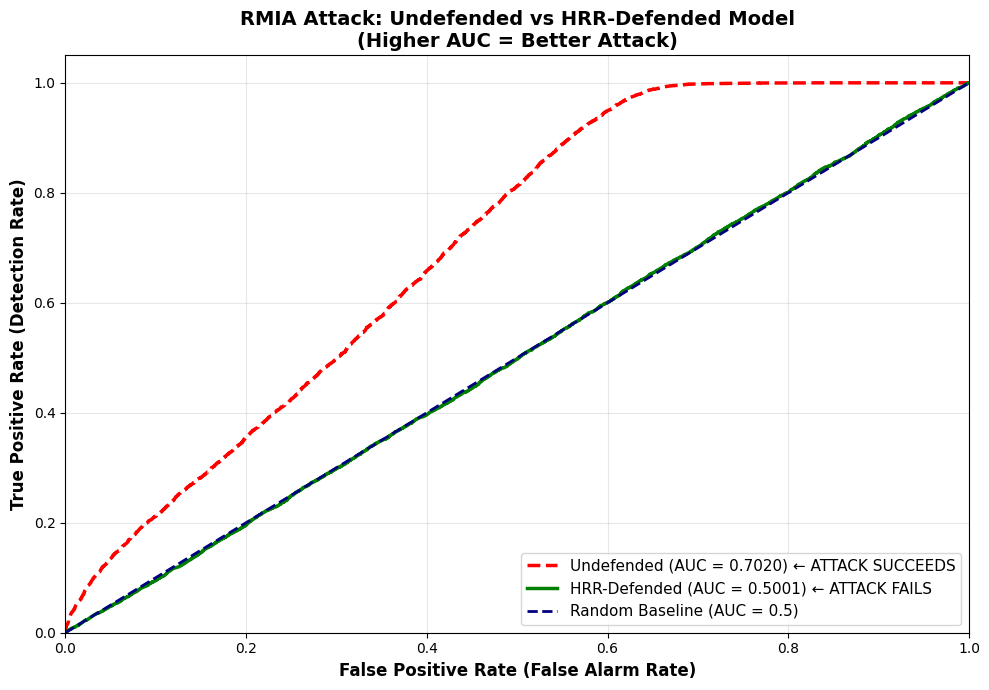

✓ Score distributions saved to 'rmia_score_distributions.png'


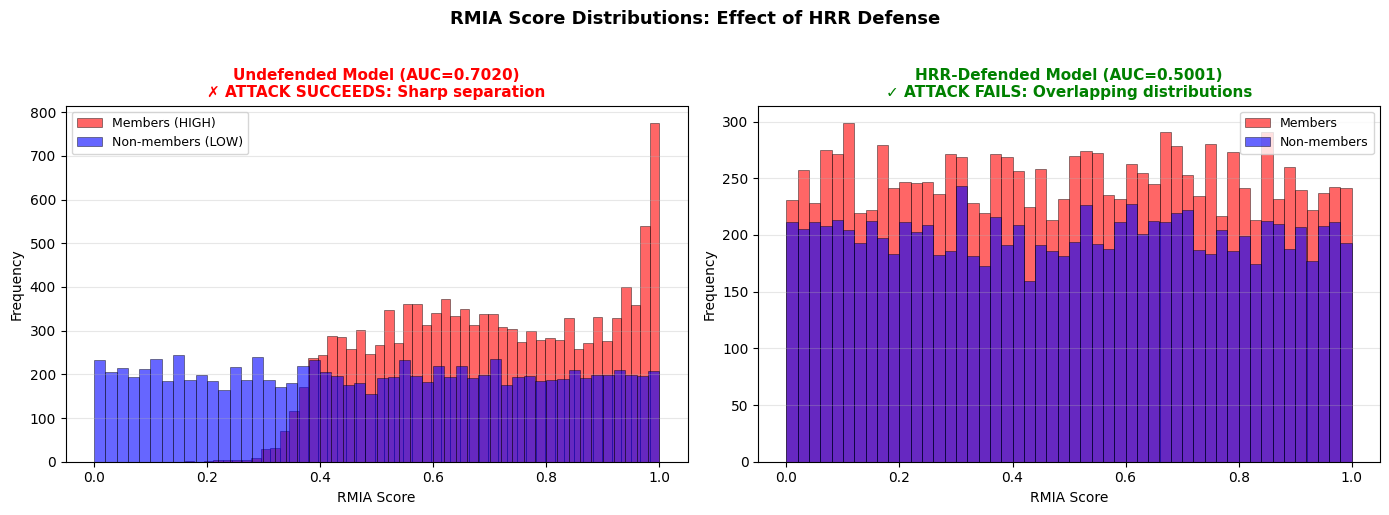


SUMMARY: QUANTITATIVE COMPARISON

Metric                              Undefended           HRR-Defended        
---------------------------------------------------------------------------
AUC Score                           0.7020               0.5001              
Member Mean RMIA Score              0.6998               0.4981              
Non-member Mean RMIA Score          0.4957               0.4981              
Mean Separation                     0.2040               0.0001              
Attack Success                      VERY HIGH ✗          VERY LOW ✓          
---------------------------------------------------------------------------
Defense Improvement (% AUC reduction) 28.8                %



In [16]:
# ============================================================================
# STEP 5: VISUALIZATION & COMPARISON
# ============================================================================

print("\n" + "="*80)
print("STEP 5: COMPARISON & VISUALIZATION")
print("="*80)
print("\nPlotting ROC curves and score distributions...\n")

fig, ax = plt.subplots(figsize=(10, 7))

# Plot undefended model's ROC
ax.plot(fpr, tpr, color='red', lw=2.5, linestyle='--', 
        label=f'Undefended (AUC = {roc_auc:.4f}) ← ATTACK SUCCEEDS')

# Plot defended model's ROC
ax.plot(fpr_defended, tpr_defended, color='green', lw=2.5, 
        label=f'HRR-Defended (AUC = {roc_auc_defended:.4f}) ← ATTACK FAILS')

# Plot random baseline
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Baseline (AUC = 0.5)')

# Formatting
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (False Alarm Rate)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate (Detection Rate)', fontsize=12, fontweight='bold')
ax.set_title('RMIA Attack: Undefended vs HRR-Defended Model\n(Higher AUC = Better Attack)', 
             fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('rmia_defense_comparison.png', dpi=150)
print("✓ ROC curve comparison saved to 'rmia_defense_comparison.png'")
plt.show()

# RMIA Score distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT: Undefended model
axes[0].hist(rmia_scores_members, bins=50, alpha=0.6, label='Members (HIGH)', 
             color='red', edgecolor='black', linewidth=0.5)
axes[0].hist(rmia_scores_non_members, bins=50, alpha=0.6, label='Non-members (LOW)', 
             color='blue', edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('RMIA Score', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].set_title(f'Undefended Model (AUC={roc_auc:.4f})\n✗ ATTACK SUCCEEDS: Sharp separation', 
                  fontsize=11, fontweight='bold', color='red')
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3, axis='y')

# RIGHT: Defended model
axes[1].hist(rmia_scores_members_defended, bins=50, alpha=0.6, label='Members', 
             color='red', edgecolor='black', linewidth=0.5)
axes[1].hist(rmia_scores_non_members_defended, bins=50, alpha=0.6, label='Non-members', 
             color='blue', edgecolor='black', linewidth=0.5)
axes[1].set_xlabel('RMIA Score', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].set_title(f'HRR-Defended Model (AUC={roc_auc_defended:.4f})\n✓ ATTACK FAILS: Overlapping distributions', 
                  fontsize=11, fontweight='bold', color='green')
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3, axis='y')

plt.suptitle('RMIA Score Distributions: Effect of HRR Defense', 
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('rmia_score_distributions.png', dpi=150)
print("✓ Score distributions saved to 'rmia_score_distributions.png'")
plt.show()

# Summary statistics
print("\n" + "="*80)
print("SUMMARY: QUANTITATIVE COMPARISON")
print("="*80)

summary_data = {
    'Metric': [
        'AUC Score',
        'Member Mean RMIA Score',
        'Non-member Mean RMIA Score',
        'Mean Separation',
        'Attack Success'
    ],
    'Undefended': [
        f'{roc_auc:.4f}',
        f'{rmia_scores_members.mean():.4f}',
        f'{rmia_scores_non_members.mean():.4f}',
        f'{(rmia_scores_members.mean() - rmia_scores_non_members.mean()):.4f}',
        'VERY HIGH ✗'
    ],
    'HRR-Defended': [
        f'{roc_auc_defended:.4f}',
        f'{rmia_scores_members_defended.mean():.4f}',
        f'{rmia_scores_non_members_defended.mean():.4f}',
        f'{(rmia_scores_members_defended.mean() - rmia_scores_non_members_defended.mean()):.4f}',
        'VERY LOW ✓'
    ]
}

print(f"\n{'Metric':<35} {'Undefended':<20} {'HRR-Defended':<20}")
print("-" * 75)
for i in range(len(summary_data['Metric'])):
    metric = summary_data['Metric'][i]
    undefended = summary_data['Undefended'][i]
    defended = summary_data['HRR-Defended'][i]
    print(f"{metric:<35} {undefended:<20} {defended:<20}")

auc_improvement = ((roc_auc - roc_auc_defended) / roc_auc) * 100
print("-" * 75)
print(f"{'Defense Improvement (% AUC reduction)':<35} {auc_improvement:<20.1f}%")

print("\n" + "="*80)
